In [ ]:
import numpy as np
import keras
from matplotlib import pyplot as plt
from scipy.io import loadmat #библиотека для загрузки .mat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [ ]:
#np.random.seed(10)


In [ ]:
from google.colab import drive #монтируем виртуальный диск для доступа к загруженным данным
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_data = loadmat('/content/gdrive/MyDrive/Colab Notebooks/train_32x32.mat')
test_data = loadmat('/content/gdrive/MyDrive/Colab Notebooks/test_32x32.mat')

In [32]:
train_img = np.array(train_data['X']) # заносим данные в массив
test_img = np.array(test_data['X'])

train_labels = train_data['y']
test_labels = test_data['y']

In [33]:
print(train_img.shape)
print(test_img.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)


In [34]:
train_img = np.moveaxis(train_img, -1, 0)
test_img = np.moveaxis(test_img, -1, 0)

                                                      #переделаем для нужд keras
print(train_img.shape)
print(test_img.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


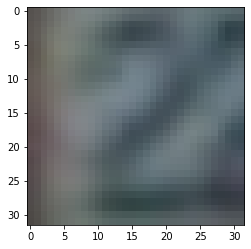

[2]


In [41]:
plt.imshow(train_img[7717])
plt.show()
print(train_labels[7717])

In [46]:
train_img = train_img.astype('float64')
test_img = test_img.astype('float64')

train_labels = train_labels.astype('int64')
test_labels = test_labels.astype('int64')

In [47]:
train_img /= 255.0 #нормализуем массивы
test_img /= 255.0

In [51]:
lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)#кодируем в 0 и 1

In [52]:
X_train, X_val, y_train, y_val = train_test_split(train_img, train_labels,
                                                  test_size=0.15, random_state=10)

In [54]:
datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)#предобработка изображений

In [57]:
keras.backend.clear_session()#Сбрасывает все состояния, созданные Keras
#настройка слоев 
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=8)#Прекратить обучение, когда метрика перестала улучшаться.
optimizer = keras.optimizers.Adam(lr=1e-3, amsgrad=True) #оптимизатор Адам - самый оптимальный
model_checkpoint = keras.callbacks.ModelCheckpoint(
                   '/kaggle/working/best_cnn.h5', 
                   save_best_only=True)#сохранить ту модель, что достигла наилучший результат
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [60]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                              epochs=10, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


487/487 [==============================] - 594s 1s/step - loss: 2.1086 - accuracy: 0.2262 - val_loss: 1.5107 - val_accuracy: 0.4312
Epoch 2/10
487/487 [==============================] - 590s 1s/step - loss: 1.6416 - accuracy: 0.3613 - val_loss: 0.9935 - val_accuracy: 0.6789
Epoch 3/10
487/487 [==============================] - 593s 1s/step - loss: 0.9572 - accuracy: 0.6753 - val_loss: 0.4881 - val_accuracy: 0.8531
Epoch 4/10
487/487 [==============================] - 590s 1s/step - loss: 0.5231 - accuracy: 0.8478 - val_loss: 0.3086 - val_accuracy: 0.9125
Epoch 5/10
487/487 [==============================] - 588s 1s/step - loss: 0.4182 - accuracy: 0.8807 - val_loss: 0.2938 - val_accuracy: 0.9184
Epoch 6/10
487/487 [==============================] - 586s 1s/step - loss: 0.3817 - accuracy: 0.8912 - val_loss: 0.2541 - val_accuracy: 0.9303
Epoch 7/10
487/487 [==============================] - 586s 1s/step - loss: 0.3438 - accuracy: 0.9015 - val_loss: 0.2679 - val_accuracy: 0.9278
Epoch 8/10

In [63]:
test_loss, test_acc = model.evaluate(x=test_img, y=test_labels, verbose=0)

print('Точность: {:0.4f} \nПотери is: {:0.4f}'.format(test_acc, test_loss))# узнаем точность и потери

Точность: 0.9472 
Потери is: 0.2140
